HOFER EXPLORATION: Using this notebook to reduce the Hofer code to its barebones so we know what is necessary for the model.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import warnings
from glob import glob

# Transformation

In [2]:
class UpperDiagonalThresholdedLogTransform:
    def __init__(self, nu):
        self.b_1 = (torch.Tensor([1, 1]) / np.sqrt(2))
        self.b_2 = (torch.Tensor([-1, 1]) / np.sqrt(2))
        self.nu = nu

    def __call__(self, dgm):
        if len(dgm) == 0:
            return dgm
        
        self.b_1 = self.b_1.to(dgm.device)
        self.b_2 = self.b_2.to(dgm.device)

        x = torch.mul(dgm, self.b_1.repeat(dgm.size(0), 1))
        x = torch.sum(x, 1).squeeze()
        y = torch.mul(dgm, self.b_2.repeat( dgm.size(0), 1))
        y = torch.sum(y, 1).squeeze()
        i = (y <= self.nu)
        y[i] = torch.log(y[i] / self.nu)*self.nu + self.nu
        ret = torch.stack([x, y], 1)
        return ret


In [11]:
ex = np.load('./barcodes/dim1/2000_01_SIN_data_dim1.npy')

In [13]:
ex.shape

(1113, 2)

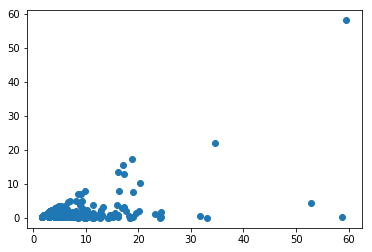

In [12]:
transformer = UpperDiagonalThresholdedLogTransform(.1)
t = transformer(torch.tensor(ex, dtype=torch.float32))
y = t.numpy()
plt.scatter(y[:,0], y[:,1])

### SLayer

In [84]:
def prepare_batch(batch: [Tensor], point_dim: int=None)->tuple:
    """
    This method 'vectorizes' the multiset in order to take advances of gpu processing.
    The policy is to embed all multisets in batch to the highest dimensionality
    occurring in batch, i.e., max(t.size()[0] for t in batch).
    :param batch:
    :param point_dim:
    :return: Tensor with size batch_size x n_max_points x point_dim
    """
    if point_dim is None:
        point_dim = batch[0].size(1)
    assert (all(x.size(1) == point_dim for x in batch if len(x) != 0))

    batch_size = len(batch)
    batch_max_points = max([t.size(0) for t in batch])
    input_device = batch[0].device

    if batch_max_points == 0:
        # if we are here, batch consists only of empty diagrams.
        batch_max_points = 1

    # This will later be used to set the dummy points to zero in the output.
    not_dummy_points = torch.zeros(batch_size, batch_max_points, device=input_device)

    prepared_batch = []

    for i, multi_set in enumerate(batch):
        n_points = multi_set.size(0)

        prepared_dgm = torch.zeros(batch_max_points, point_dim, device=input_device)

        if n_points > 0:
            index_selection = torch.tensor(range(n_points), device=input_device)

            prepared_dgm.index_add_(0, index_selection, multi_set)

            not_dummy_points[i, :n_points] = 1

        prepared_batch.append(prepared_dgm)

    prepared_batch = torch.stack(prepared_batch)

    return prepared_batch, not_dummy_points, batch_max_points, batch_size


def is_prepared_batch(input):
    if not (isinstance(input, tuple) and len(input) == 4):
        return False
    else:
        batch, not_dummy_points, max_points, batch_size = input
        return isinstance(batch, Tensor) and isinstance(not_dummy_points, Tensor) and max_points > 0 and batch_size > 0


def is_list_of_tensors(input):
    try:
        return all([isinstance(x, Tensor) for x in input])

    except TypeError:
        return False


def prepare_batch_if_necessary(input, point_dimension=None):
    batch, not_dummy_points, max_points, batch_size = None, None, None, None

    if is_prepared_batch(input):
        batch, not_dummy_points, max_points, batch_size = input
    elif is_list_of_tensors(input):
        if point_dimension is None:
            point_dimension = input[0].size(1)

        batch, not_dummy_points, max_points, batch_size = prepare_batch(input, point_dimension)

    else:
        raise ValueError(
            'SLayer does not recognize input format! Expecting [Tensor] or prepared batch. Not {}'.format(input))

    return batch, not_dummy_points, max_points, batch_size

def parameter_init_from_arg(arg, size, default, scalar_is_valid=False):
    if isinstance(arg, (int, float)):
        if not scalar_is_valid:
            raise ValueError("Scalar initialization values are not valid. Got {} expected Tensor of size {}."
                             .format(arg, size))
        return torch.Tensor(*size).fill_(arg)
    elif isinstance(arg, torch.Tensor):
        assert(arg.size() == size)
        return arg
    elif arg is None:
        if default in [torch.rand, torch.randn, torch.ones, torch.ones_like]:
            return default(*size)
        else:
            return default(size)
    else:
        raise ValueError('Cannot handle parameter initialization. Got "{}" '.format(arg))

class SLayerExponential(torch.nn.Module):
    """
    proposed input layer for multisets [1].
    """
    def __init__(self, n_elements: int,
                 point_dimension: int=2,
                 centers_init: Tensor=None,
                 sharpness_init: Tensor=None):
        """
        :param n_elements: number of structure elements used
        :param point_dimension: dimensionality of the points of which the input multi set consists of
        :param centers_init: the initialization for the centers of the structure elements
        :param sharpness_init: initialization for the sharpness of the structure elements
        """
        super().__init__()

        self.n_elements = n_elements
        self.point_dimension = point_dimension

        expected_init_size = (self.n_elements, self.point_dimension)

        centers_init = parameter_init_from_arg(centers_init, expected_init_size, torch.rand, scalar_is_valid=False)
        sharpness_init = parameter_init_from_arg(sharpness_init, expected_init_size, lambda size: torch.ones(*size)*3)

        self.centers = Parameter(centers_init)
        self.sharpness = Parameter(sharpness_init)

    def forward(self, input)->Tensor:
        batch, not_dummy_points, max_points, batch_size = prepare_batch_if_necessary(input,
                                                                                     point_dimension=self.point_dimension)


        batch = torch.cat([batch] * self.n_elements, 1)

        not_dummy_points = torch.cat([not_dummy_points] * self.n_elements, 1)

        centers = torch.cat([self.centers] * max_points, 1)
        centers = centers.view(-1, self.point_dimension)
        centers = torch.stack([centers] * batch_size, 0)

        sharpness = torch.pow(self.sharpness, 2)
        sharpness = torch.cat([sharpness] * max_points, 1)
        sharpness = sharpness.view(-1, self.point_dimension)
        sharpness = torch.stack([sharpness] * batch_size, 0)

        x = centers - batch
        x = x.pow(2)
        x = torch.mul(x, sharpness)
        x = torch.sum(x, 2)
        x = torch.exp(-x)
        x = torch.mul(x, not_dummy_points)
        x = x.view(batch_size, self.n_elements, -1)
        x = torch.sum(x, 2)
        x = x.squeeze()

        return x

    def __repr__(self):
        return 'SLayerExponential (... -> {} )'.format(self.n_elements)

class SLayer(SLayerExponential):
    def __init__(self, *args,  **kwargs):
        super().__init__(*args, **kwargs)
        warnings.warn("Renaming in progress. In future use SLayerExponential.", FutureWarning)

In [85]:
sl = SLayer(75)

c:\users\stone\desktop\spring2019\computationaltopology\project\proj_64\lib\site-packages\ipykernel_launcher.py:159: FutureWarning: Renaming in progress. In future use SLayerExponential.


In [87]:
sl([t,t,t,t,t])

tensor([[7.5399e-04, 8.1541e-01, 3.0558e-05, 3.6511e-03, 4.8451e-07, 1.7118e+00,
         1.6325e-09, 7.1934e-05, 1.9116e-08, 1.2151e-04, 6.3446e-01, 4.3455e-04,
         3.3199e-09, 7.6988e-09, 3.8588e-10, 2.8627e-02, 2.6332e-04, 1.1084e-03,
         6.5933e-02, 2.9580e-04, 7.1572e-09, 1.2694e-05, 1.1865e-02, 1.2547e-06,
         6.0360e-04, 1.1283e-01, 7.6537e-04, 1.1485e-03, 3.8569e-06, 4.7151e-01,
         4.8199e-07, 1.1448e-06, 6.9134e-06, 2.4575e-09, 5.4510e-03, 1.3991e-02,
         7.7947e-03, 4.0029e-03, 1.8370e-06, 7.8974e-06, 1.6367e+00, 2.4451e-01,
         2.2706e-08, 4.2004e-09, 2.1340e-05, 3.5129e-05, 5.4880e-02, 7.7857e-07,
         3.6881e-05, 6.3418e-02, 2.9504e-05, 2.1616e-06, 1.3388e-07, 1.2033e-01,
         1.1202e-03, 2.7102e-04, 2.5601e-05, 2.4994e-01, 7.6192e-03, 4.4982e-04,
         7.3555e-02, 3.4146e-09, 2.7747e+00, 1.6962e-01, 3.8370e-04, 3.3427e-09,
         2.5047e-05, 2.2315e-05, 3.5160e-04, 8.0645e-09, 4.6029e-03, 1.2576e+00,
         3.2638e-01, 1.5121e